<a href="https://colab.research.google.com/github/theWellHopeErr/Cynological-Analyser/blob/master/colab_notebooks/Cynological_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Cynological-Classifier**

##Import Statements

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  !pip install -U "tensorflow-gpu==2.0.0rc0" 

TensorFlow 2.x selected.


In [0]:
!pip install -U tensorflow_hub
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_hub in /usr/local/lib/python3.6/dist-packages (0.7.0)
Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (2.1.0)


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
import time
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import urllib.request

##Dataset Download

In [0]:
(train_examples, validation_examples), info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
)

Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteYVJM7W/stanford_dogs-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/stanford_dogs/0.2.0.incompleteYVJM7W/stanford_dogs-test.tfrecord


ERROR:absl:Statistics generation doesn't work for nested structures yet
ERROR:absl:Statistics generation doesn't work for nested structures yet


Dataset stanford_dogs downloaded and prepared to /root/tensorflow_datasets/stanford_dogs/0.2.0. Subsequent calls will reuse this data.


In [0]:
class_names = np.array(info.features['label'].names)
len(class_names)                          

120

In [0]:
def format_image(image, label = 121):
  # `hub` image modules exepct their data normalized to the [0,1] range.
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return  image, label

num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

In [0]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES,3))

In [0]:
feature_extractor.trainable = False

##Model Creation

In [0]:
model = tf.keras.Sequential([
  feature_extractor,
  layers.Dense(120)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


##Model Compilation

In [0]:
model.compile(
  optimizer='adam', 
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

##Model Training

In [0]:
EPOCHS = 3
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/3
375/375 [==============================] - 655s 2s/step - loss: 0.2005 - accuracy: 0.9430 - val_loss: 0.5538 - val_accuracy: 0.8279
Epoch 2/3
375/375 [==============================] - 651s 2s/step - loss: 0.1140 - accuracy: 0.9751 - val_loss: 0.5426 - val_accuracy: 0.8336
Epoch 3/3
375/375 [==============================] - 663s 2s/step - loss: 0.0785 - accuracy: 0.9850 - val_loss: 0.5406 - val_accuracy: 0.8364


##Plotting Graph for Accuracy and Loss

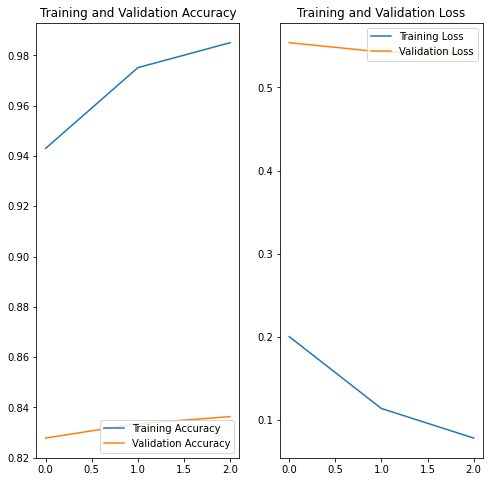

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(3)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

##Prediction

###Prediction of a Batch

In [0]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names[10:]

array(['n02108915-french_bulldog', 'n02101388-brittany_spaniel',
       'n02094258-norwich_terrier', 'n02087046-toy_terrier',
       'n02113624-toy_poodle', 'n02095314-wire-haired_fox_terrier',
       'n02093991-irish_terrier', 'n02102040-english_springer',
       'n02102480-sussex_spaniel', 'n02110063-malamute',
       'n02107908-appenzeller', 'n02102973-irish_water_spaniel',
       'n02090721-irish_wolfhound', 'n02095889-sealyham_terrier',
       'n02091134-whippet', 'n02091134-whippet',
       'n02102973-irish_water_spaniel', 'n02108000-entlebucher',
       'n02090622-borzoi', 'n02102480-sussex_spaniel',
       'n02099267-flat-coated_retriever', 'n02102480-sussex_spaniel',
       'n02100735-english_setter', 'n02107683-bernese_mountain_dog',
       'n02110806-basenji', 'n02090379-redbone', 'n02108000-entlebucher',
       'n02115641-dingo', 'n02105162-malinois', 'n02113023-pembroke',
       'n02102177-welsh_springer_spaniel',
       'n02100236-german_short-haired_pointer'], dtype='<U4

In [0]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [ 85  30  59 102  26  66 114  58  36  60  15  63  92  49   4  26  77  25
 100  97 119  56 104  30  46  80 102  41  26  13 116   9]
Predicted labels:  [ 85  30  59 102  26  66 114  58  36  60  15  63  92  49   4  26  77  25
 100  99 119  56 104  30  46  80 102  41  26  13 116   9]


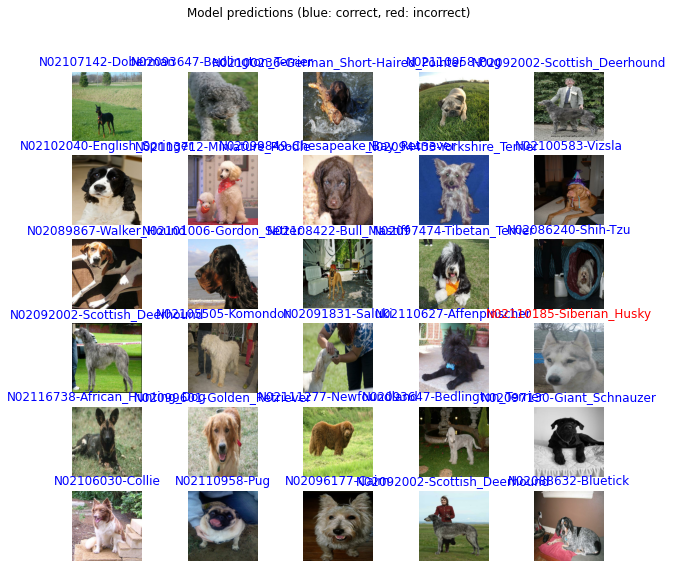

In [0]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

###Prediction of a single image with URL

n02089867-walker_hound


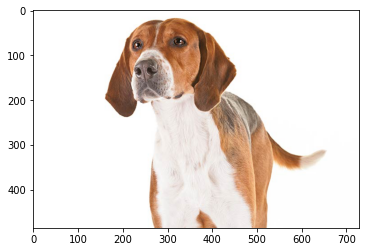

In [0]:
# chihuahua T
# url = 'https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/chihuahua-card-small.jpg?bust=1535568982'
# japanese_spaniel T
# url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSExMVFRUXGBgYGBgYFxUWFxUXFxcXFxgXFhUZHSggGBolHRcYITEhJSkrLi4uFx8zODMsNygtLisBCgoKDg0OGxAQGi0fICUrLS0tLS0tLS0tLS0tLS0tKy0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tKy0tLS0tLS0tLf/AABEIALcBEwMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAAEAAIDBQYBB//EAD4QAAEDAgMFBgQEBQQCAwEAAAEAAhEDIQQSMQUiQVFhE3GBkaHwBjKxwSNCUtEUYnKC4QeSorIz8SRj8hX/xAAZAQADAQEBAAAAAAAAAAAAAAABAgMABAX/xAApEQACAgICAgECBgMAAAAAAAAAAQIRAyESMUFREwRhInGhscHwQoHR/9oADAMBAAIRAxEAPwDDbTpgFD03qXEEuMlQQuHTJJhLCpS6FHQbKlqMTKKZkiE1U6m8rgoIunRhFqKHpIa2ouOxMLuJbCAqFVjTQyC34ooWrXUbioKj06SGHveosy4CnhiJh9Koim1ihmMRDGIUYTqhRGGrQVAaSQpkJaAXlLGWXHVQVWUXItiNGsPoUwistkBRqKftlNoDO1RIVbiMLKsWuTXhTS2BFN/CJr8IrXIo6jFSwlKaCGrNVxUpFCVcOUbMU72KJzAj6lAymGmiCgHs1LTbClc1JoWZqCKdOyZWo9EbhaUhSVqNlPo1FG5qlohTuopNprSFJAkmpJKMWxpKB1FHBqRpqPKiQLQZCLDUm01OGI8jJkGRdFREdko34dHlY1kNS6Eq01ZNoFR1KCeM6CnRT1GIV7FdOwiacCrrIh1Iq6VFEtoqxw2y3P0LR/U5rZ7pSrYJ9NxY9pa4agouYeQCGQpaaMFMcl1tG+iMWMtkIYuOpo0MUFVMEHa0BENcomsTjZEBMwyjaGGLkZ8LbNbXeA7MO4feQvWdnbCwzGiKbXHmQtwsVvweO1MK9urSPBRwve24SkRlyNjlAVFtP4DwtSS0GkT+nT/abQklj9G2ePhdyr0dn+nLA69aQJ/LB6J9X/T+lFqrp62Hv33T+KRrPMixMNEFara/wdiKUlje1bzb+2qzLw5phzS08iIKVprs1gVbBoOphFdtK4+lKCk0EzNXCGUqOEKvatBcp0gjzBZBhsOp6mHsjKbE8tQ5DFDVwygfQWgq0UHUw6VyFZRGmkrY4RdR5CWFsZldBXMUYKixNQmqT1XMRJUIpuOyZJTciQ5BUwnlxWoASHqdoQlISiCCErDYWymn/wAOEJSrwjG4hK20NYz+GCs9lbEpPvVqZROgEknlp9JQFOpJga8l6H8N7FysmoIJF+n8ojgujBFzZgCl8JYJ4hj3tdzLjfwIHogNufB1TsQCQezMNeI/8ZvBi4gz0Er0fCUmNENaAPfEog0wdQu5440Mong2K2NUpA52QQ6B3cHdxUVPZlUiRTdrExA750jqvbqmyKZblLQ4CYkaDg3uCDxmzCdIbb9IPlKVY6Gto8br4FwbmgkaSBuz/UdfBVVQFegfE2zBMmo57h+qfQn6BZJ2DU5ZFF0bmVEFOpMLnZR9gPElWD8LCP2Xgm0/xXXI0B0B6Dn14JoT5PRnM1vw21uHpABozHWL+ZOqtm7bAdlDjPcI8YWLdtF0EzHqUH8P7SaK57Qm/Tj1VJySpCxt7PZdnVJEnVGuqrN7JxzC3ddKOdiRzThTD61SBKrhtBpdl4ofFbQAbEhYwbTc3FtjQn6qOSVFcavR6EKngqr4l+GGYphMZag0cIk9CY0V3gyCLjhcImmIt5JltAkjwLGYGpReabxBBSY0r2b4o+HKeLp3htQDdfy6O5tXk+O2XXw7stRhHUbzT1BCjkg0SeiurU0ISQrGoEFWF1EFnW1lx2KUDkLXlGrDYecUmmuqk1EhXWcDWXGdJVzcSkk4sBaimCUhRuuuflMcQpGum6WyXIe6iFC+gpaczdHMp2UeUr2GwGjQKIFAonKnAI8g0BfwymZhudkWwIihTBN9E0E5SSA1Ra/DWAaIqFoHInX1Ws/jLhg14+OgWSp7QuBwHDoFYbJqzLzxJHdzPlK9mEFFUgRZtMM+3vxKMaVU4F8x3WVmBa6VnREkzKI1AeKpcdtWHENknpJTMLiXu4Ed5j6Sp8rKcfZ34jwD6jIYb+niIusFtTYNejvPpmDbMLiTppovUaLTxUhAgjUHgYI8kmTAsnZKSR5lgfharUAe7KxmsuN/IfdVHxC3s3CkDprw7yeq9K2vigxpIgR7C8g2nXL3lxuSSfBPDFHGtCeQatjA0H34Dqq/C7aazecREwTIkeevchtr1LtaLk3A+nvopsD8MGsaVOSJeHOdyEHN6adYU2uTLpJRNts/btOkwPc8ZXDUaRaCrnC/FFB7CWVA7KL66xx4rzT4wq0qbhh8PGRl3HWXSCQSbnj52AiUT8KbPfWqU6lNgcG2qCYLm9w0IE30niqqMkIoqrNXgdutxG5VcGk6QSPPihtp4M0iHtJe3WZmFlviP4Zr4PETSe406m8wmTI/S8QQXNPnbmYuAMTTw34pzzoD8wH8zuKjONFovyj2PZmImjTqc2g+l+/mrYPBvyv4LzH4Q+I//gta6z6T8hnlMg/7D6LfbKqy2P0mPDQfbzVIvVAl7LUFZH462aOzNRrZ5iAR4g6d4+i1NPSOVvDgo8fSD6bmnQiO7kfBOTkrR4U8sd8oLD+mZHhN/BBVVd7Z2cWVXSIvBGgnoOAP2KAOFlefKdOmRK8NTH0pVoMEu/wiymgooH4VD1MKQtUMEmVMAE/yBMr2RXVoTgOiSPyIxFtUAuDxxSwtRV1KqXWPBEUbFct1ojxLmmzipW1EPSfZS0UJbCkTNKIpMlMo0SeCIFKFOh9icxDvqwCiXkwqvFk5Sun6Z1OxZWyZmK18B5rT7IfIY0cf3k+keawlF8ujqPp/lbjY7spzfpA8/ceS9WLsCVM3WzR6a96ZtrHZGwDBKWBdkogk3Ik+N1g/i/bRz2OnBLJ6OiHZc0KrSYzR9T628VdUH2EDWw6/sF5psHbMug5QwHeNxPSTcn7cFuKG0bB35nDdHJvDz+kJIDzZo6dSNTJ96ITHbTa0ETdUWM2tlbAM9evErM7R2vcCdVfS7Ody9B239p5mkDisXitT79/5VnXxGb3x1/byVVihNhx9/b0Uckhsasr8NSl5eTpYcu9XmHxRaDls7KQEG2hlbA9+PHvUn8OYnj78lFt9orPoy1XZdWq4uJBdNxEAx71Ww/02x3YVHUqgc18CBEgg3kcwI8J6oWi4Ceq658lrh8zflcNRwW+ehbPW8XQpVae+AW8+R59FjfiBjGA02kRw98EHQ2/Vy5C5scTvXt6KCtJvEg+aM8qktAVmfo4k06jh+V4APgf2J817T8OYjM1rv1NaT1kCfqvF8ZTvK9J/09x2egGHVhMd0m3l9Qlg9ln0eggfsf3TalwQuUXqPE1Iv7tf6SFexGed/EtGahtfRw6jQ9bCP7SqRtMLWfGdDeFQdx6gyWH0cO9qyhavL+oTWRnO1seGhNc0JpBCHq1oUaZthIamuaoKeJUhqI20a2LIkm50keTG5GXwdEyi6tOCoM5AsjcEwvElGm+0L0T4fuspnEBcpwLLnZalJH1Rn7LTB4kQnYnFDgqVtbgEJisZHFNQORfMxg0Qu0HiCqfD1SbqTG4g5VbCm5GTbdDsBep0kfULa4E2A/U70Jj6LG7KG8Ce/wBFrNn1N9p5SfJepHoz7NVtjaAay3GfISvJduYzPUdc6wtjtbGSPBed42r+IR7m6GQviexYSr+I28NB8517gtjgtsGo5z+AuB0Fmjygf2rDCxk68uQVtsvEXjSY+slJF0xpqzU4/FbmvAevsrLbcxUgRwVjjsTNO3H391nqlSWFNOVk4RLDZ2OzC/TzAhH06cu5+/8ACyeBr5SQOa2OyagdKm9hf4WPo4cm5vOiMq4O4ZwiXdeQ+vkrbA4MWty/dJlL8V/h6WRjE0pWUlbZ45LmH2fIWkq4S3eU3D4OCZSyxiWBYLBNLSCPfBB1KJbbhwWjp0IKh2hhQ64SuGhkZevhJvFlb/Cb+xqxwN/3+x/tT6OHvCJw+Fhw6KTTTsvF+Df4Ot+6btB8QeTm+rg0+jkFs1xgDl+yh27tBtMAm8XjmB/ifRdHKo2Tm6KvbeJYWX4tBHUGCI6gAHxPMrKTHv1XcRjs7Wt4NJg8YMRPkhW1Wkcl5mXLzkc7dhLngoOq2SiKVEi65UIUrZgXsinsMKYPCjMEp7dGFKSnGGHNJLyYChODLNdCjMHjGMseKtcTszO21igMR8OOjMCSVTDlco/iVM1oEGKZnJXMZj2RDVW4+mWmIhVVUOmVWtDVZf4SsLqsxVJxJKO2YyRdT41mVsKCuPYAHAmyWJdqEVgsKTqgsSIcQuvB2NFbD9nOs09Pf0Wgo1YP9qzeAO4PfEq7Y7Q9wXdEWXZJjKlvBYfG1PxnjuHotjiHWWNxJ/Ff3ozK4jjjC6yuQZ7/AKH7prhKT6W7mGklvkAffcolSyfi/wAMeI9Sq+g+QR1KHLyAR1+qkwdnd6xqGYOnNQjotLs2pkcOX+b++iqdm0budzPoNFcdmiTn2bfZGIBb76j7JtB8v75HpP2KzWzccWSCraliQTmHOfHkjz0SNVTpTB7vfqu1aYElAYLHiwlH1XS0n3xVOSaCgeqb++q7h6Ga3vQKHEt3geCO2fz96pL2MgWphMsu/mDfufsn5QXDy8kViqZJaBz+9/t5KDEV2UvnMRJ6nuSNDXRY0sY1rTcSP3A+pWc2tjGvYKkiBLXdJJhVGEc8ve9zvmnwzGffcq7HuIkC7XAhw6Ty8J8FzSyp68EpT5aOVSBOW4PouYRoOtkJs6RIdfkpcTS3rWK4ppWAPNaLLtWnIlAUc+bWVYOqjRLTYCIUk0shPpVbkFcpXJBKa6RrGhxXVYCgBZJama0WWHeCYVkymCFkGYstcHea1Wz8QHNBQwZFJWK40UPxHsIHfasjVw5aYIXq2IZmaVjMdhmgvJGlwrt0UxvwAMwgDQeahxbSbR4qSni5gKxa9rmxwUeewp12M2bh4py8QD8p5rLbTbDz3rSbQx+doizGWas1tAS6Sur6eVs0Xsk2Y6xHUK6putHRUezR9QruNOpAXoRBLsZiX2KyON+dxC0uMqWKpalLUrSZTGBMfH2RlG7SORafEyEHVZ9VJhqkSOYPmL/YqbY7H16QU+Gw2s2J06DqnU7m6fTrtGsk8APqSh5AmE4elGn/ALVixnH33onZGDz6hXFfZcC3lxTJOhJtGeqMKdQrkWRFbDlpugKtvvH2U5IyDqWLe3T3xWnwONzM11bPdwNvLyWOp4gZi3kSPKytcE8zb2EsZNBaNbhd8X8e/mFb4LDQSO5U2xjPmtNh2roi7VmQ9uD3/P7rHfHbA2qD0+oH7fVbilWBnmDHrZZX4yoiplqjg2HDiBJgxy6pMyvGwS6MG/FP0Gn2TajiG5jdWFINEhBdlJLRovNEAqj/AMwSYS4yj8Rhg1vgmNrNDyA2DGbSIngB0+ym0mbiSuJbCirYm+nemsrEnmp62HGbqmSTWgV7ImvBPL6WEruQEhwnXgk+GwQn4Jmag0zcHIepbb1grNGYS5h4GySloOGUdyS1AplFi8UN0dw9RwVvsLauU5Tp9pWdJ36ckQQHEjhmJDZ+vgn0qnzAWJkHnmGuvmp48fGAz2ep0qktlZvae8S3gU7Yu0yaUu5A+MXQ+JrSSR3JM+dRSBFbKjHFmZrI0FyFK3KG2dIXamCzCbz6qupB/aCmJDXEz/b79FsWSOXS1RmjmHZmDp0BdHDiVHtDCyQG8hzRdR7WucQZBMDyAJ6XB8kypiw0ZrSePIch74r1PpsO+TBeyGjhhTFzc+i7iK0O8J9Xf4Q38TJkm3vUoN+JzZ3eA8tffNdkmvAVY/H15sPev7KHNIQtWpeeH1Ts9lK7RaIgLef0TabLj371T6engfopKFNIOdps4XkyJ105BF4XCsve+n3hdps0t7MKelAcJ0nQa9YWg242SbNL8Pkgc/dlo6YmyzGzKsGPLW8iy0uHqiQDr7j33q0Xom2UO2Whsk6f5WQrVpLgOB/wtV8bj8EgakiO4XPfYLM4KhLyeBuf7iSI9FGb/FRWPRNh6BJaeJ+wj7LR7Joc0BhKRmT79wtBsalmOXib+RutBbA2Wuzhldy4H+k/KfA2/uJV7TxMOgcGz33IH/VVuPaKbQ60ZajHdzmGJ/uaB4lBYXGRWyEy4AM75MtPjnHryRcuMq+4LosqeOOd3I7v92aWn6/7jyWZ2ttJzXNc0/LunuIEhwOoPJH7Qjs65afyhw5iMs+mYKkxNdpdfRxJM85In0v38oUM+RrSAQYtzY7Vo3dS2+6eLR5iO8a3TXYgAZmjX9p/ddxeUSByk9zf/wBKbYgDarKTohx46lsZo7iCBPULkc90NXgEwBLt5+k+sybcFBicOS7tCLyWzwAmY9SrRjGmpVjTMI7wQbefohWv/wDJTOpqggc9xsnwE+am8lNxQOVEGHBboJvdS4l13dRIRjWBpMgCBp1NroeuxsMdrLgPAGZ7oQjl1tUHRTVarAGN7SCWlxcRG9Nmx5ie5dwmJ7NzhNrO/wBpGbx1RVDANqNqF43CQ4fyx8s87RIQv8FD2tiN3TuA/wDfgrRcehWtlu/BNk7xFz9UlBUqSZHG/mkp/LFdsdNGcw4LqNR5bYODSf1S0ZY5AEf8kBWqPFZ8EtLgwxqCSGmO45o8eiscbTNGk4E2cZ4/M2Q241ETbqgHODnMc4WFOO9zGn7NXTF70Ian4axoq0uzs14AkciQrPDYJzbOMgaLHtrdjULmWLXOHeNBI8/CEXivil1i0TeCJuJuPoR4dVxz+m5Woq09/kB34NLis4aSwSVSw9lNtb8wfJHKbQeiZg/iN5tl/fRxNumX1TKvxJDocy3HT5QJ+8pfp8MsUq4/qZ2A4rGNaybl5JJ4Xl0/WUC3H5hBAbawk2v9YjyR+1gIzdnnBJEEWi4jMDIdabEKx2R8M4avRLialKq05CBduZpHFwkS0zOnJerHMuPoCpdlNVIG7/LPCPmDYnukpksczL8pEmReZJNxxAtMcLwYMm4nYuR+Rxysa1rXPM8CABHEmOHJCUaTS4wYa3eDyPyiNB1Ejjr0Q+W422MmgzbWEaTQbTIc0UxJEAgTfMJ+aQUhssvdJGUODnA23oBPy/lu31VTjqDm3Is/eDhdriSJhwsYze5Vx8K2NXMNKbzPTK4AKc20k4vwbaWgOg1okusI04xIB70ytUy1CADE7pIImwPHiJHmFDiqDgSS7M0tYWkSAWvNnZTcXtGshMwWEL90n5Xxm/qys+n0VOfY/IsBUORr9JzEXFwHBs98yPAorDPkTbv4nzUIw8NYIEu3YOgJE/UaqHAVZgGwgnwGiGLKpW0J+RpsA6YOgJtzA1+hHqrmkTnvoBI6x83fqB4qgw9TQ6E7gHWZB8irOtiy0RYEAgd8HhyOWfDqn5tR+yf9/kQj+LKZNNgJuHgGORa4fuPBVmHpZbW0A62ACs8bVD6TafzOaN48pggnq7M3/kqV1UudlmJsJkcyDOnD0UnkSml9h0y2oOl+VuupPITp/wBv9qu9nj8YFv8AKI/mj7wPIqgw1YNvxe4sFuTZ99XFaDZs1azzTLQSW5J0L2QWtnkQAJ6dVSE7SaAXnxQW9k8Om7Z9QQfMeqzeGrfjNqSIdUyutxLrGegjojdvY0V6pg5WkU2X4EkOB8MxaerSOF872wAFjcS7kZls94m3j3rj+rzXktAfZaYvEnsniJzZpE6bhzAxpBZ6qmwrYLQSQZAOn6sp8bE+CKw7s1NxgFxc4u4B+eRbqWz5jjZC0ahzPaRYCm6J13Sbf1Ez4jgueU3J7NZNiRNQ8AGR3WcT/wBW+KVCpc1JIyDXrnafrl+iirVJLiLfqPIOYY5QYdaehGhCZht5sNkZMzjrBH4ZZm/uE/2qcm2w2F0qoaQSdXSToBLpgnQaqJ5LaxBGZwqFsC9mQTB8E2lTJtwEtBN/lqTmgX0lPpdnTqsquGYVYdGm88xPDdk+QRbUnsF6O0qnbEXczNcAtggAaEa3JB8F3aDsmQTIDtOJBIExx1IjooMRXGc7oBO6CS+Rcg5cpEfl1lNx4PaMZNpboZm82JvJ3lSUVxphfeg/CVs7S0MDDLd2+YtMRBPA29lAbUrh7gQPl3T1BBn6+oXHGo5xc1xEQDH9O7fgYgpVW5nGo4tzNbmItD3afLz4nhEc0qluvQE6tCODcbtc2IEeXcknnGPp7ugFxIOhuPQrizgrEbZQV6tQ0SXGC17DxFsoBB9U0UmhrWOgxckHeBLSCL+4jxs9tYBraZdAjdJAtOW11lauLPyHSRPeAP2XZDfRVOy2/hswc85RNxmEjN3HxRGyMHFdjzSJa4szOjcO5kMjRt2/8jyCr8I7tGFpNmxAvy/wicJSc0w15EmDdL8vG4gdjWiX1Mtoe5sfqDe1AHk9PxdJrjRsQ4tJn+UNvPr7lF06MA1ItnIJ5uGsf4UmKwnaNY4CQ0GOYzNcJ+l+iSOV/JdM1io7YqNmg5tM0w0OMgkhoDzmaZsZa0AqTZG08rzRBc1rmtJdGdrS50TFiN4gTMX0Cr27zck6tMf7mucPEN9FW1qc1i0kiIv3WTxalp+gUmazF4I1anaEjOG5IBmnUpk2c3kTAnqAqkYQtyfIWEAAgtIcAQckAm93ExxEaJuG2kaUghpY4QQTeCTnyngd2fAJlChqxu81u+DNiwgGegIv/akb0ZWuw/E4IGkzs2DK6Q5oI/8AI12UuA13m5SDwAcocBS/AxBBkBhc06Df3Cxx5h3SxlOw1UuoVJEkBtRo0MscWVBHDdcR3FT4CG0KzCTvuYASdWufLXcoLY9hO5at/wBowHh8M52HaMsuYHWESWMeXuFtSGkOA5U3Ko2RTOcNIcAakyZuBFx0mPJX+z8W2i4ZQ8vpucQ0AEuc0kwBO8C0ARxBjiiKOBoUi5oqOIdBZnByg1BJaCDIyggSLAxe6PN8H7GKdrxVD3t0AcL8C0HK8HqM3n0UjMOczzq6JAmA3tGmrIvGrsusbpViaGXI0AuDCSSXF34cBrW3c6wbEXtl7kylhhLCBLGsNOZ+YhznAxrJBOqnzWNP9DBWBxIyjOy4ZlMfq5xwsmYzExMAzDcupzQSZnkDr0Gt1HRs8ta4ua9rjBtkeDMR1HEaiOSJw8ZdJdOS/BrgZ9YU3kpNeHsTyTZMtB2UawXO/UYaWCOWVp1/lCqqfzAnQtlp4GAQJ+vgVaMxf4MQSHZZtdhvBPTdg9S1AUy02ltgGawCM2UQOck+aXm5RV99B6Jzu021MocWvcTIkXYBc/l+U6EIzZOLdQqB7S67Q5pkQBP8wOhAHRD1sNFPsjcZm89+8OHgDPgjtnNa7DDKQ51N4cTu5gxzg7Mw/laQG26d0mLmo69hXsiGKBe95ALZkRAlpd2jZBmNXnx7kq2GId+GDlc2WgDVu+QSBMGB/wAkDVe8F4BbLRLYc0tyjeFh0Bt+6k2dtGoSH58rm5W0/wAxa0hrmhwkEglx48COFzx5WmChwptLRAIzEsF+A3gWni3M3vklQ03htQO4BonWCA0CdNIBcuYljHkOc4UwBmaG3MyXAQLNdLdOQB4onaBy9oQ9jg9o3mua4ZHFheWQBB1Ea242KDiltmaIKjwD2hkDKeBaH7rNRHyhzY5Kx2RhDUbVggAwSZIDQ4A68TH5dVW4kNy9k505RuPEkuhwLIF7WMjkZU2KxdJsUySMrQYAb80nK7k6b3mwNkVBNWamNxWMDRSDJcABrYF2VubXSxBvzKDdULgBlkUzDQTcsMCY5ZgL/wD2BFYhhAa1zBnlxOm9JsS39UCJ9JkmDE4qJaZkttewJ/xeZSxxpOzdhFbF56wqNJdn3i2CXMLdbfmGgA7x1I1Sg57nOY7ixoE3Jy3g6C7uJGqWH3S143d2AbSYJl3KQQfAA2lWGzy6pUeWwN1zpMWcXNHGL9/HLrdPK3IxXGGmXT8uhFrCxNrtJnnaCi8NhiWAZcpbIIMWDnWIA1tE34hTYygQTaHtJbGYTcgkm8EhwcJGsDVOwFbNTezdzNGRpzRZzjlYSeBJaByJ5OsnK3oOmSUqbSN94n+mbcPzDhHBJBOfVFpIi0GJBFjMhJLzkTpAn/8ATbUaWuFoVV2FOmZcJBOsJJJowqXFN0XLXDYGi7MGWN2m3eD91LV2c9u8IIt5wb+QSSXHLLOGSkwD8NV7Q5X/ACtblA6lpAd1MgInZ2/SNP8AOxucDg5jYls8IJHeEkl62J8kmyTRT0aYa90zma4AXtcw6RxtPmhG7IfXxLmNe1sS8zN2AZQ0RoZJPlyXEkkHU/8AT/cZMLOxHVGuo5h2oEC266HGwMS0kcet0LRpFua5DqUAjhIN2nmA4PHHVJJCL019w2WWx23yuaA0NfEcWHK7zuVDhIrvqA7oc3heGsfmYALflPqupLLUHLz/ANB4ATiSx7m1TLXvILtXNdmOV7dRae8gK0biSQ6lAzUyXgWyuZLXOpk66tHmUkk7dRTHumDtJL6kucSSQCTNgQW/8YUmzqzXgi4LHZQZ1EbmbnvOI6WSSXNJWmD2OpVh2jdQWA2tDgBfuOmvLyt8M1pp1H5ocCA0ZZgEeup8kkk8IppN+icnsEqNhpMw4GCBoQ4tdr0cY7gu7GwWftKpjKwEREzeWx3EHzSSSYormFsfV3uzuQ3JB4kPaTvTMyWxoh24sUa5DQGuLQd2cpcLacoAEeNkkkZq7Ci0+Ka84ekKYyscCHaboe3eYO8F3gVTNxIcKTS0Z3S6dA3NDwNbjh49F1JOtxT/AC/YKIquVwLiTYtngJDS2LX4C/pCho4YPc/Ldup7ieIOpnqkkq8dAQ+jT+VtMRLrRAhxy93F3vVWdbZppuzPcIEw4SSXtvEGIHTTe46JJKMlScvuhkEV57LtwASWy0QAAO7053lVzMK6o3KB8oeTzhu88jqYkD6JJJoRUpJP+6BFEdXaBq77RkBdIaAMrWtsGNHVoiTyunFmVlUtMOFMc4y5mgmdTdzTBN8nVJJaCXJr8/5D/kdwFVo3nDN8plxNwZIkgTMh0kJ7HFgLm2a4lpvfIeGl4IkdySSLSTSXsVhJxY4aCwMC4FgT1MT4pJJLjeSVgo//2Q=='
# english_foxhound F
# url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12233653/English-Foxhound-On-White-01.jpg'
# beagle F
# url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Beagle_600.jpg/220px-Beagle_600.jpg'
# kerry_blue_terrier T
# url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMSEhUSExMVFhUVFRcYGBgYFxUWGBceGBgdGiAZGBkYHSggGBsmHRgYITEhJSorMC4uGyAzODMsNygtLisBCgoKDg0OGhAQFy0dHR0tLS0tLSstLS0tLS0tLS0tLS0tLS0tLS03LS0tKy4rLS0tLSsrMS0tKy8tLTArLTcrOP/AABEIARMAtwMBIgACEQEDEQH/xAAcAAEAAgMBAQEAAAAAAAAAAAAABAcDBQYCAQj/xAA3EAABAwIEAwcCBQQDAQEAAAABAAIRAyEEEjFBBVFhBhMiMnGBkaHBB0JSsfAUI9HhYnLx4jP/xAAYAQEBAQEBAAAAAAAAAAAAAAAAAQIDBP/EABwRAQEBAQEBAQEBAAAAAAAAAAABAhEhMRITA//aAAwDAQACEQMRAD8AvFERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBEXwlB9RfAUc4ASdAg+ouFxP4s8NZUNM1KhgwXtpuLNYMHUjqB6SuzwGMp1qbatJwex4lrhoR/NkGdERAREQEREBERAREQEREBERAREQFyX4idsG8OoBzcrqz3ZWNJ0Au55G4GnqQq+/ED8T67n1sLhposY803VPEKpymDGndiQRz6hVVxCs8hznEkm0mSSSZkk3JRZFi8N7XY19fvxiKj2kjwkkM5gBogQJhWM38QmQ0OpHMY0Mt63iR8KmOD0stJg2aJnqY09ySpNbiDGSS6ahJAG3r13t/hRrkWfx7tmx9qLnB03EAAg6h0a/6Wg43x7FYnCGhmyNJ8TjILhEhuY6tnXe0Kva2JqAuqToJjaxv6e33Wx4Lxd2QsL7OFgSYF/5ZDjkOMUu7dAO5k3XSdlO3eNwdPJQqjJJ8Dmh7Z5gG7ediFqu0uDdOaBB9fhaTh+INN/Q2I/m6qVd3Zb8Ya9WrSo1sOx5qPazNSLmkZiAPC4kEyRuFci/NX4WYUVOKYYGkSwOe+SJEtY4tJ9CAR1hfpVEoiIiCIiAiIgIiICIiAiIgIiIKL/GjsvUbiji6dMd1Va0OLZJ7xoMl4jwjKG30sd1wVGk2AXCY06nmv1LxGo6BTZGZ83OjWjzOPOJAjmRtKo7ttwTCUHZqLozVHAMBB8LBBflA8AzggDfYWuWOcbiXZQxthBn6f6+ig4xwDCXNk33g2jcdXaD7LzXq7fpMx1XtjmugmbNzRBA10vr1UbYsI4lgaWiIi97kyJn1iVGOBqOe1gLGkugEuDGzBN3Os3T5hbF+LIDcoAk6HlcT6yIWFtbMQSQIJtGpP2QfMLWMNpvE5iNwdeoXsdmnOrimym55c7LDZJB6xotrwvBMq1G1HeEtcLbWI0i28q5uweFph1V4EuLnAuhhsI0PmbrobHVIl8R+wv4eswRp16lRzqzWkBoIDG5hEW8xjeY6Lu0RVgREQEREBERAREQEREBERAREQc521xHd0g8lzW5slRzCQ4U3XcGkEQSGxmm0zyX5zxWNNarnLWsEghjRDW8mgfHqrv8Axb4k9mHFLuz3dR7Q5+YXH6QJm516etqGeyHjXz3+o/wo1I+sxBAIESHAuncf7K88JqEuLqtSJMwT1O32XoYQ+MgkQwGetvvK1eGhxAdNnTM9fruEVucU+m2rmFRr2ZXEjcRpY6XhYsRSbBcx12PLSN4gX+fuoVekA7OLcyTa2w3Oi2lDCHIZ1d4iTEgRAzciRJ9wit5weg4mGu5WMwHSLH2KvDsTic9MtIALTtvP5j1MBUbwCq/NUMjzNubWIn7N9lZ3YDisEEw1phplwABgk6nmLe6kXU8WSi+Ar6tOQiIgIiICIiAiIgIiICIiAiIg1/GOEUsS3LVYHQQRzBBDrHaS0L8x8Xo9251MsIc3KMvJ2pvqSSBK/Vioz8YeCiniHvYCO8Dah5alrr+uU+6lbyrCviSWuvrFvQ/tdQ6BcZIi1h/k81sK2EIy7hzbH9weRmR8HdY6VGIGinWuMFIODvFf1voZn6LbYXFNIEiW3e6fzbCfgD3UR7MrspFjvvfry0WXuyfABE7enPl/tTq8dTwBrXk5jcte4nQS4EWHQQByXU4MjDsaTBcHBxECCB4QDzM5iuI4FSc94BJgltJsWi4BPyuqbis7HeGXZGB5v5iW6GNJkxNpKnTXkXB2d4ocRS7whovHhMj/AEtoqq7AY2pSrZDDGHzCSS46ANbfOSdIv+ytULo5URERBERAREQEREBERAREQEREBarjfAKOKy963NlDgPR0SPotqiChu3HZengSWSX033YT4XNuJE72Iv6rh3svlNyd9CfVXx+K/ChWwwdux3wLyR7x7SqWOHyPAcNCD8xHssXx2zexAqUZ121/z+31WPA1HBxDWySQL/b4U6i2HuaZgyB0vp7TK2nZ3hwk1SNNB67/AM5rFvIur+Z1u8DTa1jYsGgOLoAggTbfUm/ovVWsCwQMomdRpoJI52soePh4AmGAgEDfT/5MfReKOKb3bgIMmzRrY6RHvfSCszuuV5czX+nNaTKOMNI5mvylpkAGDbadgdFZvYvtezFtbTd4auWYJmeYnnF/T0KqYVKrfBMh3MAk2v8AvELLwp5pVGFoaCx8eEmZFw6Ymf8AxdpXex+gEWHCVs7Gu5tB+Qsy05iIiAiIgIiICIiAiIgIiICIvL3QJQcp254s1rO5iXOuLhpG1psdQqyx3DmwzMQx0Xt4Y0H0/dbvtXxPvKzmPDQYIBBcGOnTPmOotf8AZcZja7y/K+H+GMwLnNAGwjb15LGnXPibV4SC4uzNMbgy07Nk8767qXQw4pmxDnGBABIN9vSI+FqsPhXCS2nDQJIzhodGmXm6LfKnOLnU7U3Q0AwZD25dp2NpWON9esZVL81MAT4TAAIBFgD/AMj8CAopw7/CbyRaBlFjcOymbTYqPhHlziGt0gzDosBafy3Oukrd52uh2cF3zptqSQqjXillDMxaD5iGkkATaDuTz9VjwtfujnLsoOjRb7X91Jq0m5MpyyTJM5XesnqoGKYQABBE3IuLD0toqLk7C9oGVqQpkgObzIGaSdAbyPTkusVJ9kmhh75pgtggGSJmxO8K4+H1nPptc8AOIvEx6ibweq3K5anElERVkREQEREBERAREQEREBY8R5TaeiyLy/Q+nqgpztfVoNJIpkSTqWuJvFiDouQo08oD25buJDXEMm0anW28rte2VBzKhcAA0udrJj2MSuZDKbhemx4F4HgJA9Tp7+y512jJhy2sDTqHuqoEtymQ4CNb9dJ2XypSMf3HOcRaW2gjkJ05kSJWWjTpVHNYxhFUXbleW5LakgaRqVNoVX0s7XOaahILXEEgje5JOvXl0UVF4eDQ7zO0tEN1aXEyNSJtE7rDh8a2cooNkmxtB2m9wCvuKJBIzNOeSXMkAkxqJ9plfcPU713ibJBAgAjLE+ITtHRFSceWva/yksjQSJ6brV4ukGsEAayYJBt9dyPdbF9AS8wCWls3gOaRrI1uolLENzOD2AR1s366oiR2f4hliAcuwt9/dXB2U4h31EG5gxJMn0NtQqNwNGHyx9pmBBj23Vu/h7XaWPAdJsSL77gaAW2AW8sadgiItOYiIgIiICIiAiIgIiIC8vEiF6XwoK07a1A1+V0d3fST7k7k/T6qvsXSptc1n9owASXFwyl3iid7EXVj9sMM5rjOXKy/WNvmNORKr3FMpDMXfmu1waS5gIBAcIi1lz19ds/E3gdU0i0w2S8klg1abBttdT8qVUNN7QKgDnMaYcSWgy6DfqBN7T9dJ2f4iC7K4FvjAbJBcbz/ADlK6HEV2Cm9oFzo0CXGLR/1GvuVi1uRrKtPI3+20OtMkjlm9ZuF7qVXNpMqhndvdHP8t5tpJDfWVq6uLYfFmLH+IZYEHlcnwnQSvNDj7nNDYJddgOXaNc0iFUdLisI3L3jQSxzc8ti4zXAHINhanGYNwdLDnY5uWLNMkS0ibT06EKXwDigd3E5szGluRoJaZ/M7YNiCTvyXviGHERlcPA0uvAZlbnO13A5WwghYWoIEMy8zGt402I6cirE7FUslWxBBmLmwiYj2VdVntZWc5stY5/hPmDiBqDpBEe5K6zhGL7qm5wJaR1ImQPgmQJ6rWWdLWRa3gPExiKTX2kgExMb9ByWyXRxEREBERAREQEREBERAREKDke19DNLXeU+LrDQB73VS8QogF0iTTDgeczGp2kqze1gLnVHS4Q3LmN7EizQACNd/VVkMZlqPlxJkzYGQdfquenbHxrsA5r6BFwabwYMA+IRA5+vouyfhX94ajXNJysqAlwAcIyuBDjbQE9Sud4XRDahgDJUvcXgXB6aj2jmt/wARZNMtbZz2ua0v81w0kWHIge3qud+ukajFUqWIrVWNaC2P/wBATEtaJc3Yj1G3VQsHwtzmsc0TZzS2bA5ZjqY+ZC27MvdCmxkNg5nauLWQCAGi5Njvqo/Z6u38xAaASAZEZTERuSD6kwtSssWHomm5+HEhwbaCQQXCcpImSPupr6opN/NUl3dkzPmEZgJvtHOCvtfBtZTqZjBfZseZznXc4nYSdOTVExbGsbTqfmNSCL5YbZ1uRMQUDG1acOa0WFbOY0HlEj2hbXE4139OS12R0AyYAe2wJ9rcvotRUwuoE2fN92Rr12B9Fm4rQLsOGvJsDDiLERMO5WAvzC1Klje9i+PPpOGZ7sktytIiRHiO5M6zB2Vt0K7XiWkEdF+YaGNAygT4bAgm950mFYXY/jtUEf3HZbGNB7gb9TMLUrnYuFFhwlcVGNe0kgiQTaVmWmBERAREQEREBERARF8JQcN2zod24luaXDNBJdMFukmw1+VVhyuc9rpab3g2vN4XcdsuKf3HES8sztkmGsE3vzm0X3gLkP6vxlxEOyyR9jHQ/Rcq75+Ircf3eQEhzWtjNLgHkDwhwAnKOW8Dkts7GvNNzfzw17HbllQX9CJItsfdaqrwtphzJsdDFuhINj6hesVRqsa1+mgkO0DYEQNrgfCy0zMxUWI1Pi2BtHtYTbn8fKFJoqm0zeYnQg+3VfKXEs9OoajACDawg2106AfClcPr52PIEEW0gmfy8x905w6kVXzTc43yElp/4kzH0I9ivHFKIqEBsOY6mYAMaDNb9LrT6iFKFBoa2mT5pLjytBJHKC6BzKiY7E93TploPeuL3BnQkESdIDRHUz1VR5YyalnQQ1u36miI9Qb+gTilAGmZgA+aCLEa+g3WathznpvpjwtGTlmANonU/wCl87RP7zuyGgu8Xijk2BPO5+iQriqGLphw8JO4BsPm8/C63s1iSXhsNHikAAXG8bdVzeIwIzFrTo4kHfqB6ax1K23BasPANnDkNOZHQ/dbYXd2PohlJwBmar3fJn/XWJi63y5/se4GlMhxtJAidYXQLbnREREEREBERAREQFre0FcsoOLZk2mQ2BqSSdBAK2S57tyZwrmTGbpPlIdpIta5Uqz6qDi1QPqlgMtc14LgTEwSIG8EN+DzUVompMDXKRbUQInqZWXiLxUqASRm3daBB0A8uoWLD02tNQCYJALZvBG+0Subul0sKXEGHAixnX35xH1C+4xmSQ64JmPYXHK8esLLwplQ7kwLjWItM/CgcU4dje8MUnPaCb8wJgC4h14n4UEPEtyDxGzjod9xHQArbdk2EmQSW5iIkRcWjmRP/i5/EcOxbqZz0KmcEuHhECRBA5AAWut92GNVmHcyq1+ZtTNcHykCGgm2oPPVBn4lUMkU7ku00HMAcwBH0Wqxz3MqNquBcMoBtsbxHQ3910lYzncTBkgWvDwWgg7GTJWv4m8d3Rfq1wDXAXI9J5RvsgjsBpuDxLqbw0nlcWIhbHiFAljS0iALOFjcG8c7j5UHC0XU8uV4dSOkW0NxHMKfj6ZAAc7wjSwA/kGfZBoK+CYXuY1xIytLXCxD2kA+xmFseG4QOOWYIAg7ggaemqxPptZUbaxmwvqAZB3KnUGtL3PaYcBBHMD8w6jVXqcdl2X4maEF0wXBj2ggwSQ2W877a39lYLHTzVQ4HGllWCASIM3EwYm1yJk22Vo8IxXeMDp25rcrnqJ6Ii0wIiICIiAiIgLku3nEGU2BpPiglrQAbiIzdOn+F0+Lqua2WsLzMACB7knQKjO2fHTUrODg/NmIOWQANN7GCNJ9+WdVvE7ULiGOc97XR5Xjk2xmSJ83T2UYUZqkAQXgQTdhEAFwO8axGx5KJ3rdnl2jnEstqCXAgEc9D7rd0KrHZb587mlpLoa0QAMttZD7C91ydnT9j8BTOaSBUNwB5TM21vI29V2LsGBstd2R4L3bS7xQ4gtzEEwWgnoATeOYncrpu4XXM8cd31z2KpwNFpsSxuV5Nrek3XZ4jCzstHxLA+Ezpbl90pn64F1Yio8EEBrQQ6dYMlt9D4gsZwzH0hR1kBw5Bw3Hvb3Uvi9Bt72Yc2roJ1vyNpg8yo3D8oaGudOWd76TPzIhcnZg4QxwaBcZSAQZIImJj7rzj+Iw80XNJBadGwHG8QZuB9+UqZhKJe4vhzYcLbaiRt/CsfaLgWMf/cotc9rTMNLSQfKRBIsAAfiyT0vjk8ZiXB4bJLWNHm8wJb/x130mw1tK+4LiVRlSG5XhwnIc8x05mxCV8EWvpsc1zYJa8ubUbmjaSbyFOwvB6+IrNa2m+QyM2VwMaeaA33Wk62WK4m51JpY1zS0wcpJIiDEa7c+fRdZ2NxtZ7Rkq7eHNlF50IPPpdY8F+HlVzA19Yt5taJB9TIM+i67sp2S/pSXOqF5P/ENvzNzJiyslZuo6TBPcWAuEHks6AIujiIiICIiAiIgKoPxB7FYl+IdVpUzVY92YiASLRpMn6q30Us6svFA4Xstj84Aw9UMgiSba6EE6EEib6BdFwHsDXfl79vdsa4HJYmxBsZtcG/Uq24X2FPxGv6VFwmHygCLAAD2UnKF9RaYY6jFoeM4YOHidAGu312XRLW8cwPe0XsGrmuG+4jYhFip+KVxQJH5ZLs9r5omDz0bpPSy0/wDVMALgXDO6Ad3Oy+WbfXqsHGsS9hqNrtbaWQZDmiwlp0dZzjPMFc53R/tTUdkDgbxLpMA5SOUiY0XDj0R3mGxD2m4yty3IDSJjTUwTa28Kw+yJdUbsWQIdO+9tR6FVdwBjn1XUyHAz4g6LiTDoAAAj5zaWVv8AZXB9zTIc5hJMkgnxdcp8vpdXM9Z3ZxtnYJjhDmgjqAf3WUUQNl975v6h8hO+b+ofIXZweg0BfV475v6h8hO+b+ofIQe0Xjvm/qHyE75v6h8hB7ReO+b+ofIXxBkREQEREBERAREQEREBERBxfG+DUMQXCrTa7xG8XF9iLhc5U/D3DFwdmqWi0ti22krs8R53f9j+6xqcXqDwvgFKgCadPXVxlxMdSp0Kd/UN58udvoold0uJCqPJYeR+ELTyUuu8AuudIy+y896A4kzoLR6XQR8h5H4XwNPJSW1he/5pmDf43Xh9a0A6uJPogwlh5H4XxSK9UEa3nqPnqo6AiIg6hERAREQEREBERAREQEREHN4jzu/7H91jREBERAJQlEQEREBERAREQf/Z'
# golden_retriever T
# url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Golden_retriever.jpg/684px-Golden_retriever.jpg'
# pug
# url = "https://upload.wikimedia.org/wikipedia/commons/f/f0/Mops_oct09_cropped2.jpg"

urllib.request.urlretrieve(url, 'a.jpg')
image = plt.imread("a.jpg")
image,label = format_image(image)

image = np.array(image)
plt.imshow(image)

image = np.expand_dims(image, 0)
a = model.predict(image)
predicted = tf.squeeze(a).numpy()
predicted_ids = np.argmax(predicted, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

##Exporting Model and Saving the Model

In [0]:
t = time.time()

export_path_sm = "./{}".format(int(t))
print(export_path_sm)

tf.saved_model.save(model, export_path_sm)

./1584588473
INFO:tensorflow:Assets written to: ./1584588473/assets


INFO:tensorflow:Assets written to: ./1584588473/assets


In [0]:
!ls {export_path_sm}

assets	saved_model.pb	variables


In [0]:
!zip -r model.zip {export_path_sm}

  adding: 1584588473/ (stored 0%)
  adding: 1584588473/saved_model.pb (deflated 93%)
  adding: 1584588473/variables/ (stored 0%)
  adding: 1584588473/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: 1584588473/variables/variables.index (deflated 78%)
  adding: 1584588473/assets/ (stored 0%)


In [0]:
!ls

1584585440  1584585472.h5  1584588473  a.jpg  model.zip  sample_data


##Downloading the Model

In [0]:
try:
  from google.colab import files
  files.download('./model.zip')
except ImportError:
  pass

##Exporting Model and Saving as .h5 Model

In [0]:
t = time.time()

export_path_keras = "./{}.h5".format(int(t))
print(export_path_keras)

model.save(export_path_keras)

./1584588522.h5


In [0]:
!ls

1584585440     1584588473     a.jpg	 sample_data
1584585472.h5  1584588522.h5  model.zip


##Downloading the Model

In [0]:
try:
  from google.colab import files
  files.download(export_path_keras)
except ImportError:
  pass

---

#**Loading and Prediction**

##Import Statements

In [0]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  !pip install -U "tensorflow-gpu==2.0.0rc0" 
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import urllib.request


##Dataset Download

In [0]:
(train_examples, validation_examples), info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    with_info=True,
    as_supervised=True,
)


In [0]:
classes = np.array(info.features['label'].names)

In [0]:
def format_image(image, label = 121):
  # `hub` image modules exepct their data normalized to the [0,1] range.
  image = tf.image.resize(image, (224, 224))/255.0
  return  image, label
  
num_examples = info.splits['train'].num_examples

BATCH_SIZE = 32
IMAGE_RES = 224

train_batches      = train_examples.cache().shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.cache().map(format_image).batch(BATCH_SIZE).prefetch(1)

##Image Selection

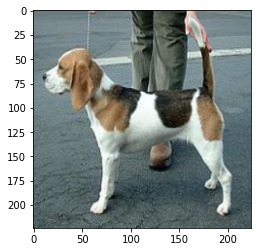

In [0]:

# chihuahua T
# url = 'https://d17fnq9dkz9hgj.cloudfront.net/breed-uploads/2018/08/chihuahua-card-small.jpg?bust=1535568982'
# japanese_spaniel T
# url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMTEhUSExMVFRUXGBgYGBgYFxUWFxUXFxcXFxgXFhUZHSggGBolHRcYITEhJSkrLi4uFx8zODMsNygtLisBCgoKDg0OGxAQGi0fICUrLS0tLS0tLS0tLS0tLS0tKy0tLS0tLS0tLS0tLS0tLS0tLS0tLS0tKy0tLS0tLS0tLf/AABEIALcBEwMBIgACEQEDEQH/xAAbAAABBQEBAAAAAAAAAAAAAAAEAAIDBQYBB//EAD4QAAEDAgMFBgQEBQQCAwEAAAEAAhEDIQQSMQUiQVFhE3GBkaHwBjKxwSNCUtEUYnKC4QeSorIz8SRj8hX/xAAZAQADAQEBAAAAAAAAAAAAAAABAgMABAX/xAApEQACAgICAgECBgMAAAAAAAAAAQIRAyESMUFREwRhInGhscHwQoHR/9oADAMBAAIRAxEAPwDDbTpgFD03qXEEuMlQQuHTJJhLCpS6FHQbKlqMTKKZkiE1U6m8rgoIunRhFqKHpIa2ouOxMLuJbCAqFVjTQyC34ooWrXUbioKj06SGHveosy4CnhiJh9Koim1ihmMRDGIUYTqhRGGrQVAaSQpkJaAXlLGWXHVQVWUXItiNGsPoUwistkBRqKftlNoDO1RIVbiMLKsWuTXhTS2BFN/CJr8IrXIo6jFSwlKaCGrNVxUpFCVcOUbMU72KJzAj6lAymGmiCgHs1LTbClc1JoWZqCKdOyZWo9EbhaUhSVqNlPo1FG5qlohTuopNprSFJAkmpJKMWxpKB1FHBqRpqPKiQLQZCLDUm01OGI8jJkGRdFREdko34dHlY1kNS6Eq01ZNoFR1KCeM6CnRT1GIV7FdOwiacCrrIh1Iq6VFEtoqxw2y3P0LR/U5rZ7pSrYJ9NxY9pa4agouYeQCGQpaaMFMcl1tG+iMWMtkIYuOpo0MUFVMEHa0BENcomsTjZEBMwyjaGGLkZ8LbNbXeA7MO4feQvWdnbCwzGiKbXHmQtwsVvweO1MK9urSPBRwve24SkRlyNjlAVFtP4DwtSS0GkT+nT/abQklj9G2ePhdyr0dn+nLA69aQJ/LB6J9X/T+lFqrp62Hv33T+KRrPMixMNEFara/wdiKUlje1bzb+2qzLw5phzS08iIKVprs1gVbBoOphFdtK4+lKCk0EzNXCGUqOEKvatBcp0gjzBZBhsOp6mHsjKbE8tQ5DFDVwygfQWgq0UHUw6VyFZRGmkrY4RdR5CWFsZldBXMUYKixNQmqT1XMRJUIpuOyZJTciQ5BUwnlxWoASHqdoQlISiCCErDYWymn/wAOEJSrwjG4hK20NYz+GCs9lbEpPvVqZROgEknlp9JQFOpJga8l6H8N7FysmoIJF+n8ojgujBFzZgCl8JYJ4hj3tdzLjfwIHogNufB1TsQCQezMNeI/8ZvBi4gz0Er0fCUmNENaAPfEog0wdQu5440Mong2K2NUpA52QQ6B3cHdxUVPZlUiRTdrExA750jqvbqmyKZblLQ4CYkaDg3uCDxmzCdIbb9IPlKVY6Gto8br4FwbmgkaSBuz/UdfBVVQFegfE2zBMmo57h+qfQn6BZJ2DU5ZFF0bmVEFOpMLnZR9gPElWD8LCP2Xgm0/xXXI0B0B6Dn14JoT5PRnM1vw21uHpABozHWL+ZOqtm7bAdlDjPcI8YWLdtF0EzHqUH8P7SaK57Qm/Tj1VJySpCxt7PZdnVJEnVGuqrN7JxzC3ddKOdiRzThTD61SBKrhtBpdl4ofFbQAbEhYwbTc3FtjQn6qOSVFcavR6EKngqr4l+GGYphMZag0cIk9CY0V3gyCLjhcImmIt5JltAkjwLGYGpReabxBBSY0r2b4o+HKeLp3htQDdfy6O5tXk+O2XXw7stRhHUbzT1BCjkg0SeiurU0ISQrGoEFWF1EFnW1lx2KUDkLXlGrDYecUmmuqk1EhXWcDWXGdJVzcSkk4sBaimCUhRuuuflMcQpGum6WyXIe6iFC+gpaczdHMp2UeUr2GwGjQKIFAonKnAI8g0BfwymZhudkWwIihTBN9E0E5SSA1Ra/DWAaIqFoHInX1Ws/jLhg14+OgWSp7QuBwHDoFYbJqzLzxJHdzPlK9mEFFUgRZtMM+3vxKMaVU4F8x3WVmBa6VnREkzKI1AeKpcdtWHENknpJTMLiXu4Ed5j6Sp8rKcfZ34jwD6jIYb+niIusFtTYNejvPpmDbMLiTppovUaLTxUhAgjUHgYI8kmTAsnZKSR5lgfharUAe7KxmsuN/IfdVHxC3s3CkDprw7yeq9K2vigxpIgR7C8g2nXL3lxuSSfBPDFHGtCeQatjA0H34Dqq/C7aazecREwTIkeevchtr1LtaLk3A+nvopsD8MGsaVOSJeHOdyEHN6adYU2uTLpJRNts/btOkwPc8ZXDUaRaCrnC/FFB7CWVA7KL66xx4rzT4wq0qbhh8PGRl3HWXSCQSbnj52AiUT8KbPfWqU6lNgcG2qCYLm9w0IE30niqqMkIoqrNXgdutxG5VcGk6QSPPihtp4M0iHtJe3WZmFlviP4Zr4PETSe406m8wmTI/S8QQXNPnbmYuAMTTw34pzzoD8wH8zuKjONFovyj2PZmImjTqc2g+l+/mrYPBvyv4LzH4Q+I//gta6z6T8hnlMg/7D6LfbKqy2P0mPDQfbzVIvVAl7LUFZH462aOzNRrZ5iAR4g6d4+i1NPSOVvDgo8fSD6bmnQiO7kfBOTkrR4U8sd8oLD+mZHhN/BBVVd7Z2cWVXSIvBGgnoOAP2KAOFlefKdOmRK8NTH0pVoMEu/wiymgooH4VD1MKQtUMEmVMAE/yBMr2RXVoTgOiSPyIxFtUAuDxxSwtRV1KqXWPBEUbFct1ojxLmmzipW1EPSfZS0UJbCkTNKIpMlMo0SeCIFKFOh9icxDvqwCiXkwqvFk5Sun6Z1OxZWyZmK18B5rT7IfIY0cf3k+keawlF8ujqPp/lbjY7spzfpA8/ceS9WLsCVM3WzR6a96ZtrHZGwDBKWBdkogk3Ik+N1g/i/bRz2OnBLJ6OiHZc0KrSYzR9T628VdUH2EDWw6/sF5psHbMug5QwHeNxPSTcn7cFuKG0bB35nDdHJvDz+kJIDzZo6dSNTJ96ITHbTa0ETdUWM2tlbAM9evErM7R2vcCdVfS7Ody9B239p5mkDisXitT79/5VnXxGb3x1/byVVihNhx9/b0Uckhsasr8NSl5eTpYcu9XmHxRaDls7KQEG2hlbA9+PHvUn8OYnj78lFt9orPoy1XZdWq4uJBdNxEAx71Ww/02x3YVHUqgc18CBEgg3kcwI8J6oWi4Ceq658lrh8zflcNRwW+ehbPW8XQpVae+AW8+R59FjfiBjGA02kRw98EHQ2/Vy5C5scTvXt6KCtJvEg+aM8qktAVmfo4k06jh+V4APgf2J817T8OYjM1rv1NaT1kCfqvF8ZTvK9J/09x2egGHVhMd0m3l9Qlg9ln0eggfsf3TalwQuUXqPE1Iv7tf6SFexGed/EtGahtfRw6jQ9bCP7SqRtMLWfGdDeFQdx6gyWH0cO9qyhavL+oTWRnO1seGhNc0JpBCHq1oUaZthIamuaoKeJUhqI20a2LIkm50keTG5GXwdEyi6tOCoM5AsjcEwvElGm+0L0T4fuspnEBcpwLLnZalJH1Rn7LTB4kQnYnFDgqVtbgEJisZHFNQORfMxg0Qu0HiCqfD1SbqTG4g5VbCm5GTbdDsBep0kfULa4E2A/U70Jj6LG7KG8Ce/wBFrNn1N9p5SfJepHoz7NVtjaAay3GfISvJduYzPUdc6wtjtbGSPBed42r+IR7m6GQviexYSr+I28NB8517gtjgtsGo5z+AuB0Fmjygf2rDCxk68uQVtsvEXjSY+slJF0xpqzU4/FbmvAevsrLbcxUgRwVjjsTNO3H391nqlSWFNOVk4RLDZ2OzC/TzAhH06cu5+/8ACyeBr5SQOa2OyagdKm9hf4WPo4cm5vOiMq4O4ZwiXdeQ+vkrbA4MWty/dJlL8V/h6WRjE0pWUlbZ45LmH2fIWkq4S3eU3D4OCZSyxiWBYLBNLSCPfBB1KJbbhwWjp0IKh2hhQ64SuGhkZevhJvFlb/Cb+xqxwN/3+x/tT6OHvCJw+Fhw6KTTTsvF+Df4Ot+6btB8QeTm+rg0+jkFs1xgDl+yh27tBtMAm8XjmB/ifRdHKo2Tm6KvbeJYWX4tBHUGCI6gAHxPMrKTHv1XcRjs7Wt4NJg8YMRPkhW1Wkcl5mXLzkc7dhLngoOq2SiKVEi65UIUrZgXsinsMKYPCjMEp7dGFKSnGGHNJLyYChODLNdCjMHjGMseKtcTszO21igMR8OOjMCSVTDlco/iVM1oEGKZnJXMZj2RDVW4+mWmIhVVUOmVWtDVZf4SsLqsxVJxJKO2YyRdT41mVsKCuPYAHAmyWJdqEVgsKTqgsSIcQuvB2NFbD9nOs09Pf0Wgo1YP9qzeAO4PfEq7Y7Q9wXdEWXZJjKlvBYfG1PxnjuHotjiHWWNxJ/Ff3ozK4jjjC6yuQZ7/AKH7prhKT6W7mGklvkAffcolSyfi/wAMeI9Sq+g+QR1KHLyAR1+qkwdnd6xqGYOnNQjotLs2pkcOX+b++iqdm0budzPoNFcdmiTn2bfZGIBb76j7JtB8v75HpP2KzWzccWSCraliQTmHOfHkjz0SNVTpTB7vfqu1aYElAYLHiwlH1XS0n3xVOSaCgeqb++q7h6Ga3vQKHEt3geCO2fz96pL2MgWphMsu/mDfufsn5QXDy8kViqZJaBz+9/t5KDEV2UvnMRJ6nuSNDXRY0sY1rTcSP3A+pWc2tjGvYKkiBLXdJJhVGEc8ve9zvmnwzGffcq7HuIkC7XAhw6Ty8J8FzSyp68EpT5aOVSBOW4PouYRoOtkJs6RIdfkpcTS3rWK4ppWAPNaLLtWnIlAUc+bWVYOqjRLTYCIUk0shPpVbkFcpXJBKa6RrGhxXVYCgBZJama0WWHeCYVkymCFkGYstcHea1Wz8QHNBQwZFJWK40UPxHsIHfasjVw5aYIXq2IZmaVjMdhmgvJGlwrt0UxvwAMwgDQeahxbSbR4qSni5gKxa9rmxwUeewp12M2bh4py8QD8p5rLbTbDz3rSbQx+doizGWas1tAS6Sur6eVs0Xsk2Y6xHUK6putHRUezR9QruNOpAXoRBLsZiX2KyON+dxC0uMqWKpalLUrSZTGBMfH2RlG7SORafEyEHVZ9VJhqkSOYPmL/YqbY7H16QU+Gw2s2J06DqnU7m6fTrtGsk8APqSh5AmE4elGn/ALVixnH33onZGDz6hXFfZcC3lxTJOhJtGeqMKdQrkWRFbDlpugKtvvH2U5IyDqWLe3T3xWnwONzM11bPdwNvLyWOp4gZi3kSPKytcE8zb2EsZNBaNbhd8X8e/mFb4LDQSO5U2xjPmtNh2roi7VmQ9uD3/P7rHfHbA2qD0+oH7fVbilWBnmDHrZZX4yoiplqjg2HDiBJgxy6pMyvGwS6MG/FP0Gn2TajiG5jdWFINEhBdlJLRovNEAqj/AMwSYS4yj8Rhg1vgmNrNDyA2DGbSIngB0+ym0mbiSuJbCirYm+nemsrEnmp62HGbqmSTWgV7ImvBPL6WEruQEhwnXgk+GwQn4Jmag0zcHIepbb1grNGYS5h4GySloOGUdyS1AplFi8UN0dw9RwVvsLauU5Tp9pWdJ36ckQQHEjhmJDZ+vgn0qnzAWJkHnmGuvmp48fGAz2ep0qktlZvae8S3gU7Yu0yaUu5A+MXQ+JrSSR3JM+dRSBFbKjHFmZrI0FyFK3KG2dIXamCzCbz6qupB/aCmJDXEz/b79FsWSOXS1RmjmHZmDp0BdHDiVHtDCyQG8hzRdR7WucQZBMDyAJ6XB8kypiw0ZrSePIch74r1PpsO+TBeyGjhhTFzc+i7iK0O8J9Xf4Q38TJkm3vUoN+JzZ3eA8tffNdkmvAVY/H15sPev7KHNIQtWpeeH1Ts9lK7RaIgLef0TabLj371T6engfopKFNIOdps4XkyJ105BF4XCsve+n3hdps0t7MKelAcJ0nQa9YWg242SbNL8Pkgc/dlo6YmyzGzKsGPLW8iy0uHqiQDr7j33q0Xom2UO2Whsk6f5WQrVpLgOB/wtV8bj8EgakiO4XPfYLM4KhLyeBuf7iSI9FGb/FRWPRNh6BJaeJ+wj7LR7Joc0BhKRmT79wtBsalmOXib+RutBbA2Wuzhldy4H+k/KfA2/uJV7TxMOgcGz33IH/VVuPaKbQ60ZajHdzmGJ/uaB4lBYXGRWyEy4AM75MtPjnHryRcuMq+4LosqeOOd3I7v92aWn6/7jyWZ2ttJzXNc0/LunuIEhwOoPJH7Qjs65afyhw5iMs+mYKkxNdpdfRxJM85In0v38oUM+RrSAQYtzY7Vo3dS2+6eLR5iO8a3TXYgAZmjX9p/ddxeUSByk9zf/wBKbYgDarKTohx46lsZo7iCBPULkc90NXgEwBLt5+k+sybcFBicOS7tCLyWzwAmY9SrRjGmpVjTMI7wQbefohWv/wDJTOpqggc9xsnwE+am8lNxQOVEGHBboJvdS4l13dRIRjWBpMgCBp1NroeuxsMdrLgPAGZ7oQjl1tUHRTVarAGN7SCWlxcRG9Nmx5ie5dwmJ7NzhNrO/wBpGbx1RVDANqNqF43CQ4fyx8s87RIQv8FD2tiN3TuA/wDfgrRcehWtlu/BNk7xFz9UlBUqSZHG/mkp/LFdsdNGcw4LqNR5bYODSf1S0ZY5AEf8kBWqPFZ8EtLgwxqCSGmO45o8eiscbTNGk4E2cZ4/M2Q241ETbqgHODnMc4WFOO9zGn7NXTF70Ian4axoq0uzs14AkciQrPDYJzbOMgaLHtrdjULmWLXOHeNBI8/CEXivil1i0TeCJuJuPoR4dVxz+m5Woq09/kB34NLis4aSwSVSw9lNtb8wfJHKbQeiZg/iN5tl/fRxNumX1TKvxJDocy3HT5QJ+8pfp8MsUq4/qZ2A4rGNaybl5JJ4Xl0/WUC3H5hBAbawk2v9YjyR+1gIzdnnBJEEWi4jMDIdabEKx2R8M4avRLialKq05CBduZpHFwkS0zOnJerHMuPoCpdlNVIG7/LPCPmDYnukpksczL8pEmReZJNxxAtMcLwYMm4nYuR+Rxysa1rXPM8CABHEmOHJCUaTS4wYa3eDyPyiNB1Ejjr0Q+W422MmgzbWEaTQbTIc0UxJEAgTfMJ+aQUhssvdJGUODnA23oBPy/lu31VTjqDm3Is/eDhdriSJhwsYze5Vx8K2NXMNKbzPTK4AKc20k4vwbaWgOg1okusI04xIB70ytUy1CADE7pIImwPHiJHmFDiqDgSS7M0tYWkSAWvNnZTcXtGshMwWEL90n5Xxm/qys+n0VOfY/IsBUORr9JzEXFwHBs98yPAorDPkTbv4nzUIw8NYIEu3YOgJE/UaqHAVZgGwgnwGiGLKpW0J+RpsA6YOgJtzA1+hHqrmkTnvoBI6x83fqB4qgw9TQ6E7gHWZB8irOtiy0RYEAgd8HhyOWfDqn5tR+yf9/kQj+LKZNNgJuHgGORa4fuPBVmHpZbW0A62ACs8bVD6TafzOaN48pggnq7M3/kqV1UudlmJsJkcyDOnD0UnkSml9h0y2oOl+VuupPITp/wBv9qu9nj8YFv8AKI/mj7wPIqgw1YNvxe4sFuTZ99XFaDZs1azzTLQSW5J0L2QWtnkQAJ6dVSE7SaAXnxQW9k8Om7Z9QQfMeqzeGrfjNqSIdUyutxLrGegjojdvY0V6pg5WkU2X4EkOB8MxaerSOF872wAFjcS7kZls94m3j3rj+rzXktAfZaYvEnsniJzZpE6bhzAxpBZ6qmwrYLQSQZAOn6sp8bE+CKw7s1NxgFxc4u4B+eRbqWz5jjZC0ahzPaRYCm6J13Sbf1Ez4jgueU3J7NZNiRNQ8AGR3WcT/wBW+KVCpc1JIyDXrnafrl+iirVJLiLfqPIOYY5QYdaehGhCZht5sNkZMzjrBH4ZZm/uE/2qcm2w2F0qoaQSdXSToBLpgnQaqJ5LaxBGZwqFsC9mQTB8E2lTJtwEtBN/lqTmgX0lPpdnTqsquGYVYdGm88xPDdk+QRbUnsF6O0qnbEXczNcAtggAaEa3JB8F3aDsmQTIDtOJBIExx1IjooMRXGc7oBO6CS+Rcg5cpEfl1lNx4PaMZNpboZm82JvJ3lSUVxphfeg/CVs7S0MDDLd2+YtMRBPA29lAbUrh7gQPl3T1BBn6+oXHGo5xc1xEQDH9O7fgYgpVW5nGo4tzNbmItD3afLz4nhEc0qluvQE6tCODcbtc2IEeXcknnGPp7ugFxIOhuPQrizgrEbZQV6tQ0SXGC17DxFsoBB9U0UmhrWOgxckHeBLSCL+4jxs9tYBraZdAjdJAtOW11lauLPyHSRPeAP2XZDfRVOy2/hswc85RNxmEjN3HxRGyMHFdjzSJa4szOjcO5kMjRt2/8jyCr8I7tGFpNmxAvy/wicJSc0w15EmDdL8vG4gdjWiX1Mtoe5sfqDe1AHk9PxdJrjRsQ4tJn+UNvPr7lF06MA1ItnIJ5uGsf4UmKwnaNY4CQ0GOYzNcJ+l+iSOV/JdM1io7YqNmg5tM0w0OMgkhoDzmaZsZa0AqTZG08rzRBc1rmtJdGdrS50TFiN4gTMX0Cr27zck6tMf7mucPEN9FW1qc1i0kiIv3WTxalp+gUmazF4I1anaEjOG5IBmnUpk2c3kTAnqAqkYQtyfIWEAAgtIcAQckAm93ExxEaJuG2kaUghpY4QQTeCTnyngd2fAJlChqxu81u+DNiwgGegIv/akb0ZWuw/E4IGkzs2DK6Q5oI/8AI12UuA13m5SDwAcocBS/AxBBkBhc06Df3Cxx5h3SxlOw1UuoVJEkBtRo0MscWVBHDdcR3FT4CG0KzCTvuYASdWufLXcoLY9hO5at/wBowHh8M52HaMsuYHWESWMeXuFtSGkOA5U3Ko2RTOcNIcAakyZuBFx0mPJX+z8W2i4ZQ8vpucQ0AEuc0kwBO8C0ARxBjiiKOBoUi5oqOIdBZnByg1BJaCDIyggSLAxe6PN8H7GKdrxVD3t0AcL8C0HK8HqM3n0UjMOczzq6JAmA3tGmrIvGrsusbpViaGXI0AuDCSSXF34cBrW3c6wbEXtl7kylhhLCBLGsNOZ+YhznAxrJBOqnzWNP9DBWBxIyjOy4ZlMfq5xwsmYzExMAzDcupzQSZnkDr0Gt1HRs8ta4ua9rjBtkeDMR1HEaiOSJw8ZdJdOS/BrgZ9YU3kpNeHsTyTZMtB2UawXO/UYaWCOWVp1/lCqqfzAnQtlp4GAQJ+vgVaMxf4MQSHZZtdhvBPTdg9S1AUy02ltgGawCM2UQOck+aXm5RV99B6Jzu021MocWvcTIkXYBc/l+U6EIzZOLdQqB7S67Q5pkQBP8wOhAHRD1sNFPsjcZm89+8OHgDPgjtnNa7DDKQ51N4cTu5gxzg7Mw/laQG26d0mLmo69hXsiGKBe95ALZkRAlpd2jZBmNXnx7kq2GId+GDlc2WgDVu+QSBMGB/wAkDVe8F4BbLRLYc0tyjeFh0Bt+6k2dtGoSH58rm5W0/wAxa0hrmhwkEglx48COFzx5WmChwptLRAIzEsF+A3gWni3M3vklQ03htQO4BonWCA0CdNIBcuYljHkOc4UwBmaG3MyXAQLNdLdOQB4onaBy9oQ9jg9o3mua4ZHFheWQBB1Ea242KDiltmaIKjwD2hkDKeBaH7rNRHyhzY5Kx2RhDUbVggAwSZIDQ4A68TH5dVW4kNy9k505RuPEkuhwLIF7WMjkZU2KxdJsUySMrQYAb80nK7k6b3mwNkVBNWamNxWMDRSDJcABrYF2VubXSxBvzKDdULgBlkUzDQTcsMCY5ZgL/wD2BFYhhAa1zBnlxOm9JsS39UCJ9JkmDE4qJaZkttewJ/xeZSxxpOzdhFbF56wqNJdn3i2CXMLdbfmGgA7x1I1Sg57nOY7ixoE3Jy3g6C7uJGqWH3S143d2AbSYJl3KQQfAA2lWGzy6pUeWwN1zpMWcXNHGL9/HLrdPK3IxXGGmXT8uhFrCxNrtJnnaCi8NhiWAZcpbIIMWDnWIA1tE34hTYygQTaHtJbGYTcgkm8EhwcJGsDVOwFbNTezdzNGRpzRZzjlYSeBJaByJ5OsnK3oOmSUqbSN94n+mbcPzDhHBJBOfVFpIi0GJBFjMhJLzkTpAn/8ATbUaWuFoVV2FOmZcJBOsJJJowqXFN0XLXDYGi7MGWN2m3eD91LV2c9u8IIt5wb+QSSXHLLOGSkwD8NV7Q5X/ACtblA6lpAd1MgInZ2/SNP8AOxucDg5jYls8IJHeEkl62J8kmyTRT0aYa90zma4AXtcw6RxtPmhG7IfXxLmNe1sS8zN2AZQ0RoZJPlyXEkkHU/8AT/cZMLOxHVGuo5h2oEC266HGwMS0kcet0LRpFua5DqUAjhIN2nmA4PHHVJJCL019w2WWx23yuaA0NfEcWHK7zuVDhIrvqA7oc3heGsfmYALflPqupLLUHLz/ANB4ATiSx7m1TLXvILtXNdmOV7dRae8gK0biSQ6lAzUyXgWyuZLXOpk66tHmUkk7dRTHumDtJL6kucSSQCTNgQW/8YUmzqzXgi4LHZQZ1EbmbnvOI6WSSXNJWmD2OpVh2jdQWA2tDgBfuOmvLyt8M1pp1H5ocCA0ZZgEeup8kkk8IppN+icnsEqNhpMw4GCBoQ4tdr0cY7gu7GwWftKpjKwEREzeWx3EHzSSSYormFsfV3uzuQ3JB4kPaTvTMyWxoh24sUa5DQGuLQd2cpcLacoAEeNkkkZq7Ci0+Ka84ekKYyscCHaboe3eYO8F3gVTNxIcKTS0Z3S6dA3NDwNbjh49F1JOtxT/AC/YKIquVwLiTYtngJDS2LX4C/pCho4YPc/Ldup7ieIOpnqkkq8dAQ+jT+VtMRLrRAhxy93F3vVWdbZppuzPcIEw4SSXtvEGIHTTe46JJKMlScvuhkEV57LtwASWy0QAAO7053lVzMK6o3KB8oeTzhu88jqYkD6JJJoRUpJP+6BFEdXaBq77RkBdIaAMrWtsGNHVoiTyunFmVlUtMOFMc4y5mgmdTdzTBN8nVJJaCXJr8/5D/kdwFVo3nDN8plxNwZIkgTMh0kJ7HFgLm2a4lpvfIeGl4IkdySSLSTSXsVhJxY4aCwMC4FgT1MT4pJJLjeSVgo//2Q=='
# english_foxhound F
# url = 'https://s3.amazonaws.com/cdn-origin-etr.akc.org/wp-content/uploads/2017/11/12233653/English-Foxhound-On-White-01.jpg'
# beagle F
url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/5/55/Beagle_600.jpg/220px-Beagle_600.jpg'
# kerry_blue_terrier T
# url = 'data:image/jpeg;base64,/9j/4AAQSkZJRgABAQAAAQABAAD/2wCEAAkGBxMSEhUSExMVFhUVFRcYGBgYFxUWGBceGBgdGiAZGBkYHSggGBsmHRgYITEhJSorMC4uGyAzODMsNygtLisBCgoKDg0OGhAQFy0dHR0tLS0tLSstLS0tLS0tLS0tLS0tLS0tLS03LS0tKy4rLS0tLSsrMS0tKy8tLTArLTcrOP/AABEIARMAtwMBIgACEQEDEQH/xAAcAAEAAgMBAQEAAAAAAAAAAAAABAcDBQYCAQj/xAA3EAABAwIEAwcCBQQDAQEAAAABAAIRAyEEEjFBBVFhBhMiMnGBkaHBB0JSsfAUI9HhYnLx4jP/xAAYAQEBAQEBAAAAAAAAAAAAAAAAAQIDBP/EABwRAQEBAQEBAQEBAAAAAAAAAAABAhEhMRITA//aAAwDAQACEQMRAD8AvFERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBERAREQEREBEXwlB9RfAUc4ASdAg+ouFxP4s8NZUNM1KhgwXtpuLNYMHUjqB6SuzwGMp1qbatJwex4lrhoR/NkGdERAREQEREBERAREQEREBERAREQFyX4idsG8OoBzcrqz3ZWNJ0Au55G4GnqQq+/ED8T67n1sLhposY803VPEKpymDGndiQRz6hVVxCs8hznEkm0mSSSZkk3JRZFi8N7XY19fvxiKj2kjwkkM5gBogQJhWM38QmQ0OpHMY0Mt63iR8KmOD0stJg2aJnqY09ySpNbiDGSS6ahJAG3r13t/hRrkWfx7tmx9qLnB03EAAg6h0a/6Wg43x7FYnCGhmyNJ8TjILhEhuY6tnXe0Kva2JqAuqToJjaxv6e33Wx4Lxd2QsL7OFgSYF/5ZDjkOMUu7dAO5k3XSdlO3eNwdPJQqjJJ8Dmh7Z5gG7ediFqu0uDdOaBB9fhaTh+INN/Q2I/m6qVd3Zb8Ya9WrSo1sOx5qPazNSLmkZiAPC4kEyRuFci/NX4WYUVOKYYGkSwOe+SJEtY4tJ9CAR1hfpVEoiIiCIiAiIgIiICIiAiIgIiIKL/GjsvUbiji6dMd1Va0OLZJ7xoMl4jwjKG30sd1wVGk2AXCY06nmv1LxGo6BTZGZ83OjWjzOPOJAjmRtKo7ttwTCUHZqLozVHAMBB8LBBflA8AzggDfYWuWOcbiXZQxthBn6f6+ig4xwDCXNk33g2jcdXaD7LzXq7fpMx1XtjmugmbNzRBA10vr1UbYsI4lgaWiIi97kyJn1iVGOBqOe1gLGkugEuDGzBN3Os3T5hbF+LIDcoAk6HlcT6yIWFtbMQSQIJtGpP2QfMLWMNpvE5iNwdeoXsdmnOrimym55c7LDZJB6xotrwvBMq1G1HeEtcLbWI0i28q5uweFph1V4EuLnAuhhsI0PmbrobHVIl8R+wv4eswRp16lRzqzWkBoIDG5hEW8xjeY6Lu0RVgREQEREBERAREQEREBERAREQc521xHd0g8lzW5slRzCQ4U3XcGkEQSGxmm0zyX5zxWNNarnLWsEghjRDW8mgfHqrv8Axb4k9mHFLuz3dR7Q5+YXH6QJm516etqGeyHjXz3+o/wo1I+sxBAIESHAuncf7K88JqEuLqtSJMwT1O32XoYQ+MgkQwGetvvK1eGhxAdNnTM9fruEVucU+m2rmFRr2ZXEjcRpY6XhYsRSbBcx12PLSN4gX+fuoVekA7OLcyTa2w3Oi2lDCHIZ1d4iTEgRAzciRJ9wit5weg4mGu5WMwHSLH2KvDsTic9MtIALTtvP5j1MBUbwCq/NUMjzNubWIn7N9lZ3YDisEEw1phplwABgk6nmLe6kXU8WSi+Ar6tOQiIgIiICIiAiIgIiICIiAiIg1/GOEUsS3LVYHQQRzBBDrHaS0L8x8Xo9251MsIc3KMvJ2pvqSSBK/Vioz8YeCiniHvYCO8Dah5alrr+uU+6lbyrCviSWuvrFvQ/tdQ6BcZIi1h/k81sK2EIy7hzbH9weRmR8HdY6VGIGinWuMFIODvFf1voZn6LbYXFNIEiW3e6fzbCfgD3UR7MrspFjvvfry0WXuyfABE7enPl/tTq8dTwBrXk5jcte4nQS4EWHQQByXU4MjDsaTBcHBxECCB4QDzM5iuI4FSc94BJgltJsWi4BPyuqbis7HeGXZGB5v5iW6GNJkxNpKnTXkXB2d4ocRS7whovHhMj/AEtoqq7AY2pSrZDDGHzCSS46ANbfOSdIv+ytULo5URERBERAREQEREBERAREQEREBarjfAKOKy963NlDgPR0SPotqiChu3HZengSWSX033YT4XNuJE72Iv6rh3svlNyd9CfVXx+K/ChWwwdux3wLyR7x7SqWOHyPAcNCD8xHssXx2zexAqUZ121/z+31WPA1HBxDWySQL/b4U6i2HuaZgyB0vp7TK2nZ3hwk1SNNB67/AM5rFvIur+Z1u8DTa1jYsGgOLoAggTbfUm/ovVWsCwQMomdRpoJI52soePh4AmGAgEDfT/5MfReKOKb3bgIMmzRrY6RHvfSCszuuV5czX+nNaTKOMNI5mvylpkAGDbadgdFZvYvtezFtbTd4auWYJmeYnnF/T0KqYVKrfBMh3MAk2v8AvELLwp5pVGFoaCx8eEmZFw6Ymf8AxdpXex+gEWHCVs7Gu5tB+Qsy05iIiAiIgIiICIiAiIgIiICIvL3QJQcp254s1rO5iXOuLhpG1psdQqyx3DmwzMQx0Xt4Y0H0/dbvtXxPvKzmPDQYIBBcGOnTPmOotf8AZcZja7y/K+H+GMwLnNAGwjb15LGnXPibV4SC4uzNMbgy07Nk8767qXQw4pmxDnGBABIN9vSI+FqsPhXCS2nDQJIzhodGmXm6LfKnOLnU7U3Q0AwZD25dp2NpWON9esZVL81MAT4TAAIBFgD/AMj8CAopw7/CbyRaBlFjcOymbTYqPhHlziGt0gzDosBafy3Oukrd52uh2cF3zptqSQqjXillDMxaD5iGkkATaDuTz9VjwtfujnLsoOjRb7X91Jq0m5MpyyTJM5XesnqoGKYQABBE3IuLD0toqLk7C9oGVqQpkgObzIGaSdAbyPTkusVJ9kmhh75pgtggGSJmxO8K4+H1nPptc8AOIvEx6ibweq3K5anElERVkREQEREBERAREQEREBY8R5TaeiyLy/Q+nqgpztfVoNJIpkSTqWuJvFiDouQo08oD25buJDXEMm0anW28rte2VBzKhcAA0udrJj2MSuZDKbhemx4F4HgJA9Tp7+y512jJhy2sDTqHuqoEtymQ4CNb9dJ2XypSMf3HOcRaW2gjkJ05kSJWWjTpVHNYxhFUXbleW5LakgaRqVNoVX0s7XOaahILXEEgje5JOvXl0UVF4eDQ7zO0tEN1aXEyNSJtE7rDh8a2cooNkmxtB2m9wCvuKJBIzNOeSXMkAkxqJ9plfcPU713ibJBAgAjLE+ITtHRFSceWva/yksjQSJ6brV4ukGsEAayYJBt9dyPdbF9AS8wCWls3gOaRrI1uolLENzOD2AR1s366oiR2f4hliAcuwt9/dXB2U4h31EG5gxJMn0NtQqNwNGHyx9pmBBj23Vu/h7XaWPAdJsSL77gaAW2AW8sadgiItOYiIgIiICIiAiIgIiIC8vEiF6XwoK07a1A1+V0d3fST7k7k/T6qvsXSptc1n9owASXFwyl3iid7EXVj9sMM5rjOXKy/WNvmNORKr3FMpDMXfmu1waS5gIBAcIi1lz19ds/E3gdU0i0w2S8klg1abBttdT8qVUNN7QKgDnMaYcSWgy6DfqBN7T9dJ2f4iC7K4FvjAbJBcbz/ADlK6HEV2Cm9oFzo0CXGLR/1GvuVi1uRrKtPI3+20OtMkjlm9ZuF7qVXNpMqhndvdHP8t5tpJDfWVq6uLYfFmLH+IZYEHlcnwnQSvNDj7nNDYJddgOXaNc0iFUdLisI3L3jQSxzc8ti4zXAHINhanGYNwdLDnY5uWLNMkS0ibT06EKXwDigd3E5szGluRoJaZ/M7YNiCTvyXviGHERlcPA0uvAZlbnO13A5WwghYWoIEMy8zGt402I6cirE7FUslWxBBmLmwiYj2VdVntZWc5stY5/hPmDiBqDpBEe5K6zhGL7qm5wJaR1ImQPgmQJ6rWWdLWRa3gPExiKTX2kgExMb9ByWyXRxEREBERAREQEREBERAREKDke19DNLXeU+LrDQB73VS8QogF0iTTDgeczGp2kqze1gLnVHS4Q3LmN7EizQACNd/VVkMZlqPlxJkzYGQdfquenbHxrsA5r6BFwabwYMA+IRA5+vouyfhX94ajXNJysqAlwAcIyuBDjbQE9Sud4XRDahgDJUvcXgXB6aj2jmt/wARZNMtbZz2ua0v81w0kWHIge3qud+ukajFUqWIrVWNaC2P/wBATEtaJc3Yj1G3VQsHwtzmsc0TZzS2bA5ZjqY+ZC27MvdCmxkNg5nauLWQCAGi5Njvqo/Z6u38xAaASAZEZTERuSD6kwtSssWHomm5+HEhwbaCQQXCcpImSPupr6opN/NUl3dkzPmEZgJvtHOCvtfBtZTqZjBfZseZznXc4nYSdOTVExbGsbTqfmNSCL5YbZ1uRMQUDG1acOa0WFbOY0HlEj2hbXE4139OS12R0AyYAe2wJ9rcvotRUwuoE2fN92Rr12B9Fm4rQLsOGvJsDDiLERMO5WAvzC1Klje9i+PPpOGZ7sktytIiRHiO5M6zB2Vt0K7XiWkEdF+YaGNAygT4bAgm950mFYXY/jtUEf3HZbGNB7gb9TMLUrnYuFFhwlcVGNe0kgiQTaVmWmBERAREQEREBERARF8JQcN2zod24luaXDNBJdMFukmw1+VVhyuc9rpab3g2vN4XcdsuKf3HES8sztkmGsE3vzm0X3gLkP6vxlxEOyyR9jHQ/Rcq75+Ircf3eQEhzWtjNLgHkDwhwAnKOW8Dkts7GvNNzfzw17HbllQX9CJItsfdaqrwtphzJsdDFuhINj6hesVRqsa1+mgkO0DYEQNrgfCy0zMxUWI1Pi2BtHtYTbn8fKFJoqm0zeYnQg+3VfKXEs9OoajACDawg2106AfClcPr52PIEEW0gmfy8x905w6kVXzTc43yElp/4kzH0I9ivHFKIqEBsOY6mYAMaDNb9LrT6iFKFBoa2mT5pLjytBJHKC6BzKiY7E93TploPeuL3BnQkESdIDRHUz1VR5YyalnQQ1u36miI9Qb+gTilAGmZgA+aCLEa+g3WathznpvpjwtGTlmANonU/wCl87RP7zuyGgu8Xijk2BPO5+iQriqGLphw8JO4BsPm8/C63s1iSXhsNHikAAXG8bdVzeIwIzFrTo4kHfqB6ax1K23BasPANnDkNOZHQ/dbYXd2PohlJwBmar3fJn/XWJi63y5/se4GlMhxtJAidYXQLbnREREEREBERAREQFre0FcsoOLZk2mQ2BqSSdBAK2S57tyZwrmTGbpPlIdpIta5Uqz6qDi1QPqlgMtc14LgTEwSIG8EN+DzUVompMDXKRbUQInqZWXiLxUqASRm3daBB0A8uoWLD02tNQCYJALZvBG+0Subul0sKXEGHAixnX35xH1C+4xmSQ64JmPYXHK8esLLwplQ7kwLjWItM/CgcU4dje8MUnPaCb8wJgC4h14n4UEPEtyDxGzjod9xHQArbdk2EmQSW5iIkRcWjmRP/i5/EcOxbqZz0KmcEuHhECRBA5AAWut92GNVmHcyq1+ZtTNcHykCGgm2oPPVBn4lUMkU7ku00HMAcwBH0Wqxz3MqNquBcMoBtsbxHQ3910lYzncTBkgWvDwWgg7GTJWv4m8d3Rfq1wDXAXI9J5RvsgjsBpuDxLqbw0nlcWIhbHiFAljS0iALOFjcG8c7j5UHC0XU8uV4dSOkW0NxHMKfj6ZAAc7wjSwA/kGfZBoK+CYXuY1xIytLXCxD2kA+xmFseG4QOOWYIAg7ggaemqxPptZUbaxmwvqAZB3KnUGtL3PaYcBBHMD8w6jVXqcdl2X4maEF0wXBj2ggwSQ2W877a39lYLHTzVQ4HGllWCASIM3EwYm1yJk22Vo8IxXeMDp25rcrnqJ6Ii0wIiICIiAiIgLku3nEGU2BpPiglrQAbiIzdOn+F0+Lqua2WsLzMACB7knQKjO2fHTUrODg/NmIOWQANN7GCNJ9+WdVvE7ULiGOc97XR5Xjk2xmSJ83T2UYUZqkAQXgQTdhEAFwO8axGx5KJ3rdnl2jnEstqCXAgEc9D7rd0KrHZb587mlpLoa0QAMttZD7C91ydnT9j8BTOaSBUNwB5TM21vI29V2LsGBstd2R4L3bS7xQ4gtzEEwWgnoATeOYncrpu4XXM8cd31z2KpwNFpsSxuV5Nrek3XZ4jCzstHxLA+Ezpbl90pn64F1Yio8EEBrQQ6dYMlt9D4gsZwzH0hR1kBw5Bw3Hvb3Uvi9Bt72Yc2roJ1vyNpg8yo3D8oaGudOWd76TPzIhcnZg4QxwaBcZSAQZIImJj7rzj+Iw80XNJBadGwHG8QZuB9+UqZhKJe4vhzYcLbaiRt/CsfaLgWMf/cotc9rTMNLSQfKRBIsAAfiyT0vjk8ZiXB4bJLWNHm8wJb/x130mw1tK+4LiVRlSG5XhwnIc8x05mxCV8EWvpsc1zYJa8ubUbmjaSbyFOwvB6+IrNa2m+QyM2VwMaeaA33Wk62WK4m51JpY1zS0wcpJIiDEa7c+fRdZ2NxtZ7Rkq7eHNlF50IPPpdY8F+HlVzA19Yt5taJB9TIM+i67sp2S/pSXOqF5P/ENvzNzJiyslZuo6TBPcWAuEHks6AIujiIiICIiAiIgKoPxB7FYl+IdVpUzVY92YiASLRpMn6q30Us6svFA4Xstj84Aw9UMgiSba6EE6EEib6BdFwHsDXfl79vdsa4HJYmxBsZtcG/Uq24X2FPxGv6VFwmHygCLAAD2UnKF9RaYY6jFoeM4YOHidAGu312XRLW8cwPe0XsGrmuG+4jYhFip+KVxQJH5ZLs9r5omDz0bpPSy0/wDVMALgXDO6Ad3Oy+WbfXqsHGsS9hqNrtbaWQZDmiwlp0dZzjPMFc53R/tTUdkDgbxLpMA5SOUiY0XDj0R3mGxD2m4yty3IDSJjTUwTa28Kw+yJdUbsWQIdO+9tR6FVdwBjn1XUyHAz4g6LiTDoAAAj5zaWVv8AZXB9zTIc5hJMkgnxdcp8vpdXM9Z3ZxtnYJjhDmgjqAf3WUUQNl975v6h8hO+b+ofIXZweg0BfV475v6h8hO+b+ofIQe0Xjvm/qHyE75v6h8hB7ReO+b+ofIXxBkREQEREBERAREQEREBERBxfG+DUMQXCrTa7xG8XF9iLhc5U/D3DFwdmqWi0ti22krs8R53f9j+6xqcXqDwvgFKgCadPXVxlxMdSp0Kd/UN58udvoold0uJCqPJYeR+ELTyUuu8AuudIy+y896A4kzoLR6XQR8h5H4XwNPJSW1he/5pmDf43Xh9a0A6uJPogwlh5H4XxSK9UEa3nqPnqo6AiIg6hERAREQEREBERAREQEREHN4jzu/7H91jREBERAJQlEQEREBERAREQf/Z'
# golden_retriever T
# url = 'https://upload.wikimedia.org/wikipedia/commons/thumb/4/47/Golden_retriever.jpg/684px-Golden_retriever.jpg'
# pug
# url = "https://upload.wikimedia.org/wikipedia/commons/f/f0/Mops_oct09_cropped2.jpg"

urllib.request.urlretrieve(url, 'a.jpg')
image = plt.imread("a.jpg")
image,label = format_image(image)
plt.imshow(image)
image = np.array(image)
image = np.expand_dims(image, 0)

## .h5 Model

### Load Model as .h5 file

In [0]:
rel_model = tf.keras.models.load_model(
  "/content/1584588522.h5",
  custom_objects={'KerasLayer': hub.KerasLayer})
rel_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 120)               153720    
Total params: 2,411,704
Trainable params: 153,720
Non-trainable params: 2,257,984
_________________________________________________________________


### Predict for a single image using .h5 model

n02089867-walker_hound


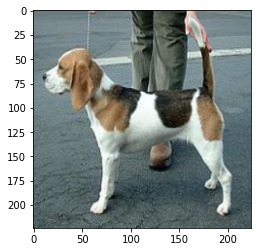

In [0]:
a = rel_model.predict(image)
predicted = tf.squeeze(a).numpy()
predicted_ids = np.argmax(predicted, axis=-1)
predicted_class_names = classes[predicted_ids]
plt.imshow(image[0])
print(predicted_class_names[10:])

### Predict for a batch of images using .h5 model

In [0]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = rel_model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = classes[predicted_ids]
predicted_class_names

array(['n02111889-samoyed', 'n02094433-yorkshire_terrier',
       'n02091134-whippet', 'n02108000-entlebucher', 'n02110063-malamute',
       'n02106550-rottweiler', 'n02106166-border_collie',
       'n02099712-labrador_retriever', 'n02088238-basset',
       'n02086646-blenheim_spaniel', 'n02115641-dingo',
       'n02113186-cardigan', 'n02085620-chihuahua',
       'n02093647-bedlington_terrier', 'n02086079-pekinese',
       'n02115913-dhole', 'n02101006-gordon_setter',
       'n02109047-great_dane', 'n02097298-scotch_terrier',
       'n02093428-american_staffordshire_terrier',
       'n02108915-french_bulldog', 'n02097474-tibetan_terrier',
       'n02112018-pomeranian', 'n02112350-keeshond', 'n02101556-clumber',
       'n02085620-chihuahua', 'n02110185-siberian_husky',
       'n02111889-samoyed', 'n02100583-vizsla', 'n02106030-collie',
       'n02111129-leonberg', 'n02095889-sealyham_terrier'], dtype='<U40')

In [0]:
print("Labels: ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:  [106  36  21  90  98  83  81  57  10   5 117 112   0  30   3 118  63  95
  48  28  94  49 107 109  65   0  99 106  60  80 103  39]
Predicted labels:  [106  36  21  90  98  83  81  57  10   5 117 112   0  30   3 118  63  95
  48  29  94  49 107 109  65   0  99 106  60  80 103  39]


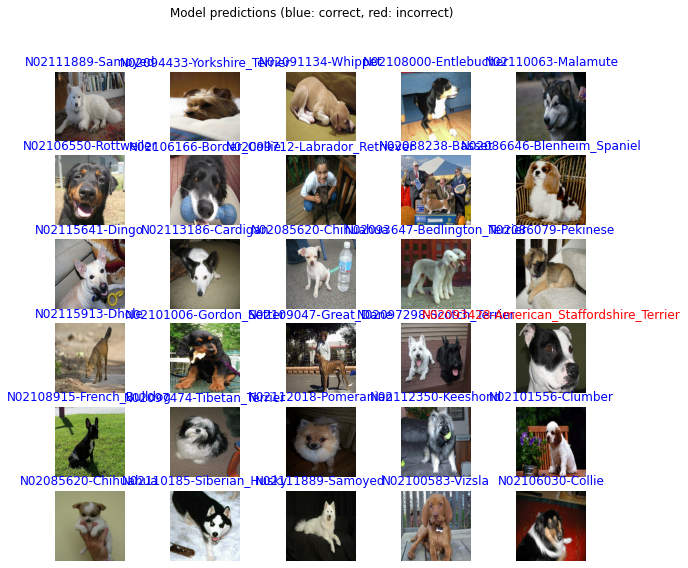

In [0]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")

## Model as a Directory

### Load Model as a Directory

In [0]:
rel_as_model = tf.saved_model.load("./model")

### Predict using Model loaded as folder

n02089867-walker_hound


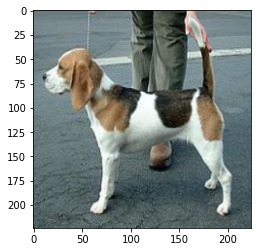

In [0]:
plt.imshow(image[0])
print(classes[np.argmax(rel_as_model(image, training=False).numpy())][10:])